In [2]:
#from structure_and_load import load
import matplotlib.pyplot as plt 
import numpy as np
import pandas as pd
import scipy.ndimage as spn 
from open_data  import matlab_file
from structure_data import  structure
from compute.classif import classify


import re
import neo 
from neo.core import Event
from quantities import s 
from quantities import millisecond as ms

import os
import sys

%load_ext autoreload
%autoreload 2

# Load data

In [3]:
lab_desktop = True

measure = 'synch'
classif = 'HistGrad'

if lab_desktop : 
    session = 't150204001'
    data_path = f'/home/INT/mifsud.l/Bureau/data/Tommy/{session}/modified_data/' #f'~/Bureau/data/Tommy/{session}/modified_data'
    info_path = '/home/INT/mifsud.l/Bureau/Lists&Documentation/TomyCerebusSpikes_Updated_June2023.xlsx'
    result_path = '~/Bureau/results'

else : 
    session = 't150204001'
    data_path = f'/home/laurie/Bureau/pattern_classification/data/Tommy_new/{session}/modified_data/'
    info_path = '/home/laurie/Bureau/pattern_classification/data/Tommy_new/session_info.xlsx'

print(f'session : {session}')

session : t150204001


In [4]:
# import data from matlab file
data, load_info = matlab_file.open(data_path)
# clean data 
df = matlab_file.clean(info_path)
# get sessions and units info 
info_units,  info_session = structure.info(load_info, df, session)
# manage elitrials format
info_session['elitrials'] = info_session['elitrials'].apply(structure.elitrials)
print(info_session.shape)

# get unit's index without eli trials 
completeUnit = structure.CompleteTasktime(info_session, load_info, session)


43 files loaded
(45, 8)
     start  stop elitrials
159      1    11      None 

unit_info : [1 3 1]
t150204001_probe1_contact3_unit1.mat

unit's loading index = 2


In [5]:
# extract data from the matlab file
spike_times = matlab_file.extract_spike_times(load_info, data)
task_data = matlab_file.extract_task_data(load_info, data, target_keys=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'], event_keys_OFF=['Sel_OFF', 'SC1_OFF', 'SC2_OFF', 'SC3_OFF'])

target_info = matlab_file.extract_target_info(load_info, data, target_keys=['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])
# get trials indices per condition
target_1 = np.where(target_info[completeUnit][1]['Trial_type'] == 1)[0]
target_2 = np.where(target_info[completeUnit][1]['Trial_type'] == 2)[0]
target_3 = np.where(target_info[completeUnit][1]['Trial_type'] == 3)[0]

event_labels = matlab_file.get_event_labels(task_data)
event_times = matlab_file.get_event_times(task_data, event_labels)
# reshape times by trials / periods for each neuron + Neo format
trials_ts, df_task_ts_by_neuron, events = structure.events_by_trial(event_times, event_labels)

unit_ = 32
trial_ = 12
print(f'times as list : {trials_ts[unit_][1][trial_]}')
print(f'times as neo events : {events[unit_][1][trial_].times}')
print(f'spike train sample : {spike_times[0][1]}\nevents : {event_labels}\ntargets : {target_info[0][1].keys()}')



times as list : [3047992 3049069 3050391 3051713 3053021 3054320 3054799]
times as neo events : [3047992. 3049069. 3050391. 3051713. 3053021. 3054320. 3054799.] ms
spike train sample : [    237    2137    3267 ... 3657198 3657250 3658579]
events : ['Touch_time', 'Sel_ON', 'SC1_ON', 'SC2_ON', 'SC3_ON', 'Go_time', 'Target_time']
targets : dict_keys(['SC1_dir', 'SC2_dir', 'SC3_dir', 'Trial_type'])


In [38]:
# get target by trial and neuron
n_units = len(target_info)

list_trial_type = []
list_position = []
list_type_and_pos = []

for unit in range(n_units):
    #print(f'neuron {unit}')
    list_trial_type.append([])
    list_position.append([])
    list_type_and_pos.append([])
    trial_type = target_info[unit][1]['Trial_type']
    n_trials = trial_type.shape[0]

    for trial in range(n_trials):
        #print(f'trial type : {trial_type[trial]}')
        valid_cue_idx = target_info[unit][1]['Trial_type'][trial] - 1
        valid_cue = list(target_info[unit][1].keys())[valid_cue_idx]
        position = target_info[unit][1][f'{valid_cue}'][trial]
        #print(f'position : {position}')
        list_trial_type[unit] = list(trial_type)
        list_position[unit].append(position)

    cue_position = list(zip(list_trial_type[unit], list_position[unit]))
    cue_pos_combinations = sorted(set(cue_position))

    # build the target accoring the combination of the cue/direction
    cue_and_pos = []
    for sel_cue, direction in cue_position:
        cue_and_pos.append(cue_pos_combinations.index((sel_cue, direction)))

    list_type_and_pos[unit] = cue_and_pos

# Data formating

In [6]:
# get dataframe with each events times per trials for a complete session
tot_trials_in_task = trials_ts[completeUnit][1].shape[0]
df_task_ts = pd.DataFrame(trials_ts[completeUnit][1], columns=event_labels, index=np.arange(0, tot_trials_in_task))
df_task_ts.tail()

,Touch_time,Sel_ON,SC1_ON,SC2_ON,SC3_ON,Go_time,Target_time
171,3427744,3428813,3430132,3431440,3432749,3434034,3434577
172,3488819,3489885,3491206,3492515,3493823,3495121,3495791
173,3498993,3500111,3501419,3502727,3504049,3505334,3506030
174,3518800,3519868,3521190,3522498,3523823,3525133,3525652
175,3534627,3535700,3537009,3538317,3539639,3540937,3541739


## units labels

In [7]:
def unit_label(info_units): 
    info_units_df = pd.DataFrame(info_units)
    count_unitProbe = list(info_units_df['probe'].value_counts(sort=False))

    n_units = len(spike_times)
    n_event = event_labels[:-1]

    unit_label = []
    unit_labelProbe1 = []
    unit_labelProbe2 = []

    for i in range(n_units):
        label = str(\
            'P' + str(info_units[i]['probe']) \
            + '-' + str(info_units[i]['contact']) \
            + '-' + str(info_units[i]['unit'])) 
        unit_label.append(label)

        if info_units[i]['probe'] == 1 :
            unit_labelProbe1.append(label)
        else : 
            unit_labelProbe2.append(label)

    return unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe

unit_label, unit_labelProbe1, unit_labelProbe2, count_unitProbe = unit_label(info_units)
print(len(unit_labelProbe1) == count_unitProbe[0])
print(len(unit_labelProbe2) == count_unitProbe[1])
unit_labelTwoprobes = unit_label

True
True


#  Trials ref 

In [8]:
n_neurons = len(spike_times)
n_trials = df_task_ts.shape[0]
n_events = df_task_ts.shape[1] - 1 

In [9]:
for unit in range(n_neurons) :
    list_idx_trial = []
    times_unit = df_task_ts_by_neuron[unit][1]
    n_trials_unit = times_unit.shape[0]

    for trial in range(n_trials_unit):

        for i, event in enumerate(event_labels[:-1]):
            #print(f'trial :{trial}')            
            t_start = times_unit.loc[trial][f'{event}']
            t_stop = times_unit.loc[trial][f'{event_labels[i+1]}']
            idx_trial = df_task_ts[df_task_ts[f'{event}'] == t_start].index[0]

        list_idx_trial.append(idx_trial)
    df_task_ts_by_neuron[unit][1].insert(0, 'idx_ref_trial', list_idx_trial)


# Spike times formating (alignement, nan for invalid trials)

In [10]:
# get spike by trial for each neuron + Neo format (SpikeTrain)
from neo.core import SpikeTrain

def spike_ts_trial(n_neurons, trials_ts, spike_times):  
    '''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

    spk_trials = []
    spike_train = []
    

    for unit_idx in range(n_neurons):
        spk_trials.append([])
        spike_train.append([])

        n_trials = trials_ts[unit_idx][1].shape[0]

        for trial in range(n_trials):
            # define the start and end time of each trial
            t_start = trials_ts[unit_idx][1][trial,0]
            t_stop = trials_ts[unit_idx][1][trial,-1]
            
            # get spikes between start and end of trial 
            spk_tmp = spike_times[unit_idx][1] 
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            
            # for trials without spikes 
            if spk_tmp[sel_spk].shape[0] == 0:
                spk_trials[unit_idx].append([])
                spike_train[unit_idx].append([])

            else :
                spk_ts_trial = SpikeTrain(spk_tmp[sel_spk]*ms, t_start=t_start, t_stop=t_stop, dtype='int32')
                # fill the matrice with spike times aligned to 0
                spike_train[unit_idx].append(spk_ts_trial)

    return spk_trials, spike_train
    

spk_trials, spike_train_trial = spike_ts_trial(n_neurons, trials_ts, spike_times)

In [11]:
'''split the spike time vector by trial RUN WITH EVENT TIMES NOT ALIGNED'''

def align_trials(df_task_ts, df_task_ts_by_neuron, spike_times):
    n_units = len(spike_times)

    for unit_idx in range(n_units):
        data = df_task_ts_by_neuron[unit_idx][1]
        list_trials_unit = list(data['idx_ref_trial'])

        nan_trials = [item for item in list_trials_task if item not in list_trials_unit]
        valid_trials = [item for item in list_trials_task if item in list_trials_unit]

        for idx_trial_valid, trial_valid in enumerate(valid_trials):
            # define the start and end time of each trial
            t_start = data.loc[idx_trial_valid][1]
            t_stop = data.loc[idx_trial_valid][-1]

            # get spikes between start and end of trial and align to zero
            spk_tmp = spike_times[unit_idx][1]
            sel_spk = np.logical_and(spk_tmp>t_start, spk_tmp<t_stop)
            spikes_times_aligned_ = []
                    
            for spk_idx, spk in enumerate(spk_tmp[sel_spk]):
                spk_aligned = spk - t_start
                spikes_times_aligned_.append(spk_aligned)
                        
            spikes_times_aligned[unit_idx][trial_valid]= {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : trial_valid, 
                        't_start_ref' : t_start,
                        't_start_aligned' : t_start - t_start,
                        't_stop_aligned': t_stop - t_start,
                        'spike_time' : np.array(spikes_times_aligned_, dtype=np.int32), 
                        'spike_train' : spike_train_trial[unit_idx][idx_trial_valid]
                        }

        for idx_trial_nan in (nan_trials):
            t_start_nan = df_task_ts.loc[idx_trial_nan][0]
            t_stop_nan = df_task_ts.loc[idx_trial_nan][-1]


            spikes_times_aligned[unit_idx][idx_trial_nan] = {
                        'unit_label': unit_label[unit_idx], 
                        'trial_unit' : idx_trial_nan, 
                        't_start_ref' : t_start_nan, 
                        't_start_aligned' : t_start_nan - t_start_nan,
                        't_stop_aligned': t_stop_nan - t_start_nan,
                        'spike_time' : np.zeros(1, dtype=np.int64),
                        'spike_train' :  np.zeros(1, dtype=np.int64)
                        }

    return spikes_times_aligned
    
list_trials_task = list(df_task_ts.index)
spikes_times_aligned = np.zeros((n_neurons, n_trials), dtype=object)
spikes_times_aligned = align_trials(df_task_ts, df_task_ts_by_neuron, spike_times)


/tmp/ipykernel_21563/3040918305.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start = data.loc[idx_trial_valid][1]
/tmp/ipykernel_21563/3040918305.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_stop = data.loc[idx_trial_valid][-1]
/tmp/ipykernel_21563/3040918305.py:38: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  t_start_nan = df_task_ts.loc[idx_trial_nan][0]
/tmp/ipykernel_21563/3040918305.py:39: FutureWarning: Se

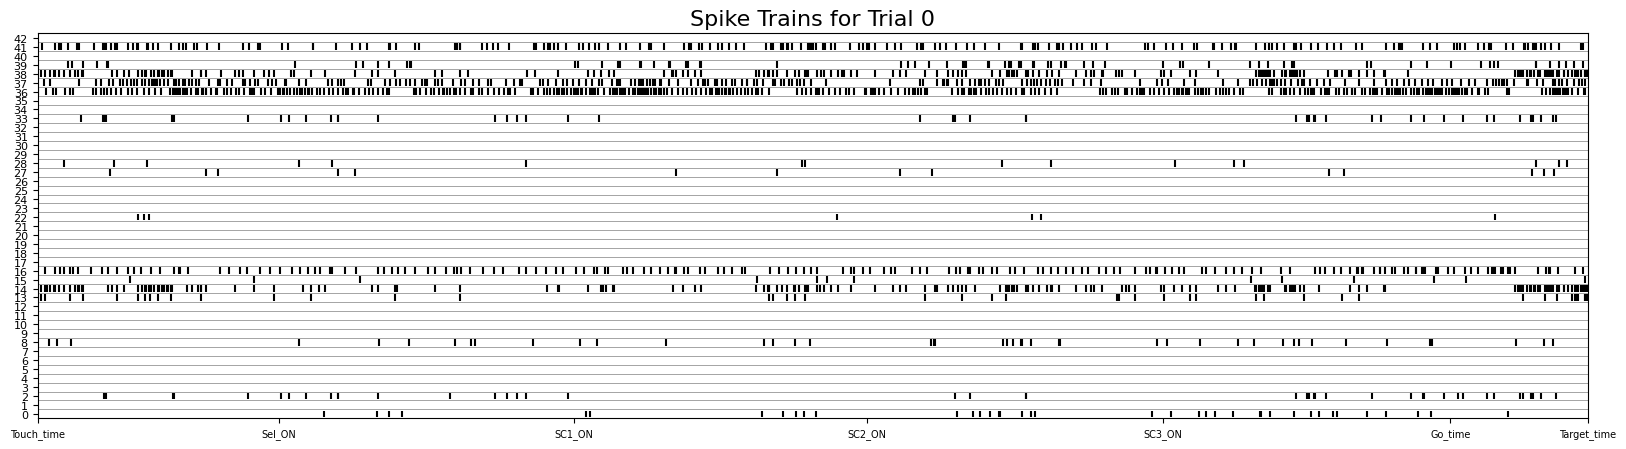

In [12]:
t = 0
event_vector = df_task_ts.loc[t]

plt.figure(figsize=(20, 5))  # Ajustez la taille de la figure selon vos besoins

# Parcourir tous les neurones et tracer leur spike train
for n in range(n_neurons): 
    spiketrain = spikes_times_aligned[n][t]['spike_train']
    if len(spiketrain) > 0 and spiketrain[0] != 0:      
        plt.eventplot(spiketrain.magnitude, linelengths=0.75, lineoffsets=n, color='black')
for i in range(n_neurons - 1):
    plt.hlines(i+0.5, xmin=event_vector.min(), xmax=event_vector.max(), colors='gray', linestyles='solid', linewidth=0.5)

# Définir les étiquettes de l'axe x et l'axe y
plt.xticks(event_vector.values, event_labels, fontsize=7)
plt.yticks(range(n_neurons), [f"{i}" for i in range(n_neurons)], fontsize=8)
plt.title(f"Spike Trains for Trial {t}", fontsize=16)

# Ajuster les limites des axes
plt.xlim(event_vector.min(), event_vector.max())
plt.ylim(-0.5, 42.5)

plt.show()


# Firing rate (fr) convolution

In [13]:
max_length = 8000
def binarize_spike_times(spikes_times_aligned):
    spikes_binarized = np.zeros((n_trials, max_length, n_neurons), dtype=float)
    for n in range(n_neurons):
        for t in range(n_trials):
            spiketrain = spikes_times_aligned[n][t]['spike_train']
            t_start = spikes_times_aligned[n][t]['t_start_ref'] 

            if len(spiketrain) > 0 and spiketrain[0] != 0:
                spk = spiketrain.magnitude - t_start
                spikes_binarized[t, spk, n] = 1 
            else : 
                spikes_binarized[t,:,n] = 0 
    
    return spikes_binarized
        
spikes_binarized = binarize_spike_times(spikes_times_aligned)

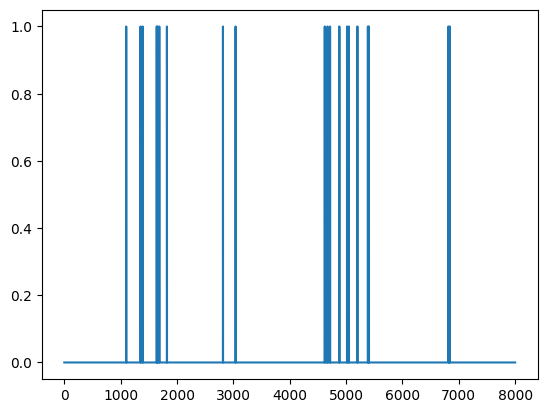

In [14]:
plt.plot(spikes_binarized[121,:,10])

In [15]:
def convolve_spike_binarized(spikes_binarized, sigma):
    n_sigma = len(sigma)
    delta_time = 1
    sigma_dt = sigma * delta_time 
    spike_convolved = np.zeros((n_trials, max_length, n_neurons, n_sigma))

    for idx, s in enumerate(sigma):
        scaling = sigma_dt[idx] * np.sqrt(2*np.pi)
        for t in range(n_trials) : 
            for n in range(n_neurons):
                smoothed_spk = spn.gaussian_filter1d(spikes_binarized[t,:,n], sigma_dt[idx]) * scaling
                spike_convolved[t,:,n,idx] = smoothed_spk
    
    return spike_convolved

In [16]:
sigma = [10, 50, 100]
spike_convolved = convolve_spike_binarized(spikes_binarized, sigma)

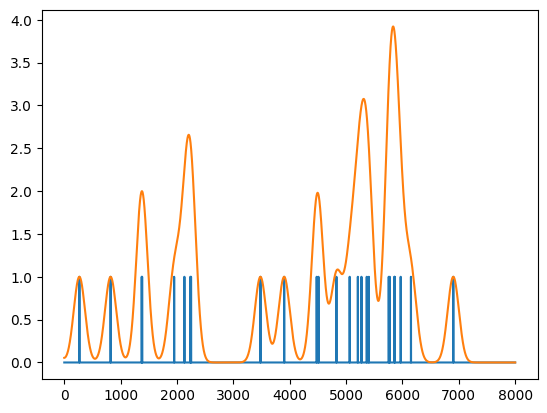

In [17]:
plt.plot(spikes_binarized[121,:,0])
plt.plot(spike_convolved[121,:,0,2])

# Synchony 

In [18]:
spike_convolved.shape

(176, 8000, 43, 3)

In [19]:
row, col = np.triu_indices(n_neurons, k=1)
n_pairs = len(row)
n_times = spike_convolved.shape[1]
Synch = np.zeros((n_trials, n_pairs, n_times))

for t in range(n_trials) :     
    for n_p, (r,c) in enumerate(zip(row, col)):
        Synch[t, n_p,:] = spike_convolved[t, :, r,2] * spike_convolved[t, :, c,2]

In [20]:
Synch.shape

(176, 903, 8000)

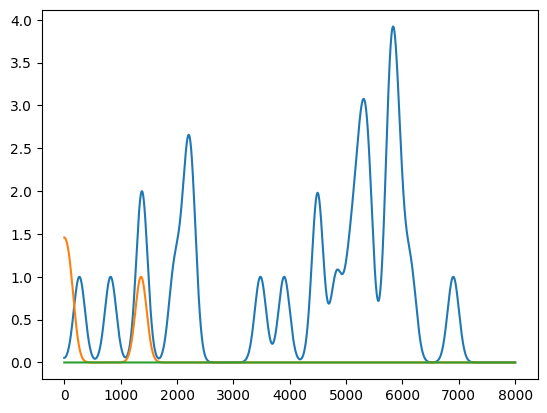

In [21]:
t = 121 
n = 0
n2 = 1
plt.plot(spike_convolved[t,:,n,2])
plt.plot(spike_convolved[t,:,n2,2])
plt.plot(Synch[t,-1,:])

# Classif 

In [22]:
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.pipeline import make_pipeline

In [23]:
# Build pipeline
# Build pipeline
n_splits = 5
# Cross-validation scheme
cvs0 = StratifiedShuffleSplit(n_splits=n_splits, test_size=0.2)
scaler = StandardScaler()
estimator = HistGradientBoostingClassifier()
clf = make_pipeline(scaler, estimator)

In [24]:
Synch[0].shape[1]

8000

In [40]:
target = pd.DataFrame(target_info[completeUnit][1]['Trial_type'], columns=['trial_type'])
target['position'] = list_position[completeUnit]

n_times = list(np.arange(0, Synch[0].shape[1], 100))
n_bins = len(n_times)

In [26]:
# Initialiser une liste vide pour stocker les moyennes de bin
Synch_mean_bin = []

# Calculer les moyennes pour chaque bin et chaque paire
for start, end in zip(n_times[:-1], n_times[1:]):
    # Extraire les données pour le bin actuel
    bin_data = Synch[:, :, start:end]
    # Calculer la moyenne sur l'axe des temps
    bin_mean = np.nanmean(bin_data, axis=2)
    # Convertir les moyennes en DataFrame et les ajouter à la liste
    bin_mean_df = pd.DataFrame(bin_mean)
    Synch_mean_bin.append(bin_mean_df)

In [27]:
Synch_mean_bin[-10]

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
0,0.0,0.000647,0.0,0.0,0.0,0.0,0.0,0.000498,0.0,0.0,...,26.786134,0.0,26.229137,0.0,0.0,7.169406,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,3.219317,0.0,26.953328,0.0,0.0,2.547105,0.0,0.0,0.0,0.0
2,0.0,0.000939,0.0,0.0,0.0,0.0,0.0,3.275830,0.0,0.0,...,54.226542,0.0,197.841381,0.0,0.0,20.629207,0.0,0.0,0.0,0.0
3,0.0,0.002307,0.0,0.0,0.0,0.0,0.0,0.673705,0.0,0.0,...,19.043310,0.0,41.321830,0.0,0.0,5.942948,0.0,0.0,0.0,0.0
4,0.0,1.417282,0.0,0.0,0.0,0.0,0.0,1.492727,0.0,0.0,...,11.932997,0.0,121.421452,0.0,0.0,8.677140,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
172,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
173,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
174,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [28]:
class Model_info:

    def __init__(self, n_splits, n_events, data, target, cvs, clf):
        self.n_splits = n_splits
        self.n_periods = n_events
        self.data = data
        self.target = target
        self.cvs = cvs
        self.clf = clf

In [42]:
list_synch_model = []

for idx, t in enumerate(n_times[:-1]):
    model_synch = Model_info(n_splits,\
             n_bins, Synch_mean_bin[idx], target['position'], cvs0, clf)
    list_synch_model.append(model_synch)

In [43]:
list_synch_model[0].data

,0,1,2,3,4,5,6,7,8,9,...,893,894,895,896,897,898,899,900,901,902
0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,27.402004,0.0,118.863781,0.0,0.0,20.389538,0.0,0.0,0.0,0.0
1,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,2.696414,0.0,15.995832,0.0,0.0,0.330035,0.0,0.0,0.0,0.0
2,0.0,0.000392,0.0,0.0,0.0,0.0,0.0,0.00144,0.0,0.0,...,43.656396,0.0,90.298822,0.0,0.0,18.381424,0.0,0.0,0.0,0.0
3,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,20.397096,0.0,71.541947,0.0,0.0,19.601539,0.0,0.0,0.0,0.0
4,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,10.058833,0.0,41.119648,0.0,0.0,16.506199,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
171,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
172,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
173,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0
174,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,...,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0


In [44]:
list_synch_model[1].target

0      2
1      2
2      3
3      3
4      4
      ..
171    3
172    3
173    4
174    4
175    4
Name: position, Length: 176, dtype: uint8

In [47]:
acc_df = pd.DataFrame(columns=['split', 'data_type', 'time', 'target_type', 'accuracy'])
data_ = list_synch_model[0].data
target_ = list_synch_model[0].target
for i_split, (train_ind, test_ind) in enumerate(cvs0.split(data_, target_)):
    print('#################')
    print('SPLIT :', i_split)
    print('##################')
    
    for idx, t in enumerate(n_times[:-1]):
        model = list_synch_model[idx]
        data = model.data
        target = model.target

        # Train classifier 
        model.clf.fit(data.loc[train_ind, :], target.loc[train_ind].values.ravel())
    
        # Test classifier 
        y_pred = model.clf.predict(data.loc[test_ind, :])
        y_true = target.loc[test_ind].values
        acc = model.clf.score(data.loc[test_ind,:], target_.loc[test_ind])

        # Save test performance
        d = {
            'split': i_split,
            'data_type': 'test',
            'time': [t],
            'target_type': target.name, 
            'accuracy': acc,
        }

        acc_df = pd.concat((acc_df, pd.DataFrame(data=d)))
    
        # Train classifier on shuffled data
        ind_train_shuf = np.random.permutation(train_ind)
        model.clf.fit(data.loc[train_ind, :], target.loc[ind_train_shuf].values.ravel())
    
        # Test classifier on shuffled data
        y_pred_shuf = model.clf.predict(data.loc[test_ind, :])
        acc_shuf = model.clf.score(data.loc[test_ind,:], target_.loc[test_ind])
        
        # Save shuffled performance
        d_shuff = {
            'split': i_split,
            'data_type': 'shuff',
            'time': [t],
            'target_type': target.name, 
            'accuracy': acc_shuf
        }
        acc_df = pd.concat((acc_df, pd.DataFrame(data=d_shuff)), ignore_index=True)


#################
SPLIT : 0
##################


/tmp/ipykernel_21563/1402058702.py:31: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  acc_df = pd.concat((acc_df, pd.DataFrame(data=d)))


#################
SPLIT : 1
##################
#################
SPLIT : 2
##################
#################
SPLIT : 3
##################
#################
SPLIT : 4
##################


In [48]:
acc_df.to_csv(f'{result_path}/{session}_{classif}_{measure}_position.csv')

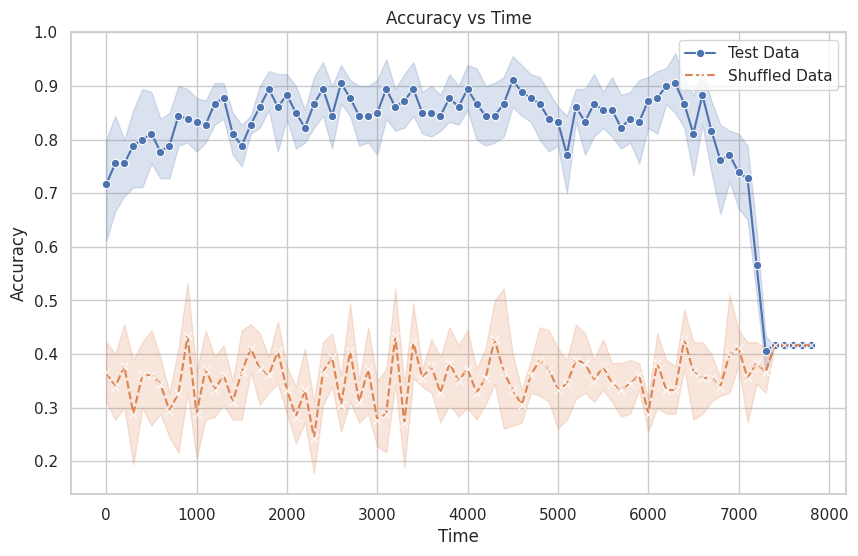

In [36]:
import seaborn as sns
import matplotlib.pyplot as plt

# Séparez les données par type
test_data = acc_df[acc_df['data_type'] == 'test']
shuff_data = acc_df[acc_df['data_type'] == 'shuff'] 

# Définir le style de seaborn
sns.set(style="whitegrid")

# Tracer les données
plt.figure(figsize=(10, 6))

# Tracer les données de test
sns.lineplot(data=test_data, x='time', y='accuracy', marker='o', linestyle='-', label='Test Data')

# Tracer les données de shuffled
sns.lineplot(data=shuff_data, x='time', y='accuracy', marker='x', linestyle='--', label='Shuffled Data')

# Définir les étiquettes d'axe et le titre
plt.xlabel('Time')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Time')

# Afficher la légende
plt.legend()

# Afficher le tracé
plt.show()
